# Overview of Image-Based Two-Phase Flow Simulations - Part 1: Drainage

PoreSpy includes several functions for simulation the displacement of one phase by another.  These include `drainage`, `imbibition`, and `invasion`.  The objectives of this tutorial are:

- Give an overview of the various ways to use the `porespy.simulations.drainage` algorithm
- Demonstrate how to define inlets and outlets
- Introduce the concept of "displacement maps", which encode the entire history of the simulation in a single image
- Define the sequence, saturation and capillary pressure maps
- Convert between sequence, saturation, and capillary pressure maps
- Explain the conventions used for dealing with trapped and residual phase in displacement maps
- Plot capillary pressure curves using the results of a drainage simulations

## Setup

As usual, we start by importing the necessary packages, and creating a test image which will be used throughout.  The test image is 2D for visualization purposes, but everything discussed here applies to 3D as well.

In [21]:
import matplotlib.pyplot as plt
import numpy as np

import porespy as ps

ps.visualization.set_mpl_style()

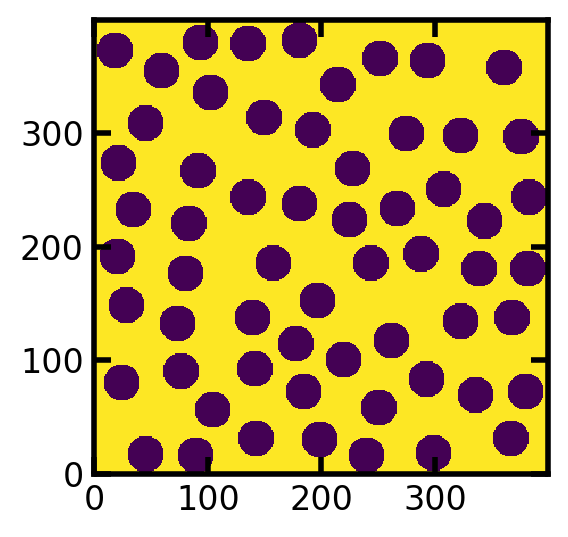

In [22]:
im = ~ps.generators.random_spheres([400, 400], r=15, clearance=10, seed=22)
fig, ax = plt.subplots(figsize=[3, 3])
ax.imshow(im);


## Pressure-Based Drainage

A common two-phase flow experiment is to apply a fixed pressure to the non-wetting phase and monitor the volume of void space that is invaded.  Repeating this process at progressively higher pressures results in a drainage curve. Using PoreSpy this can be simulated as follows:

### Define Inlets

First we create a boolean image with `True` values where we would like the invading fluid to enter the domain.  We can do this manually using `numpy`, or use PoreSpy's built-in features:

In [23]:
inlets = np.zeros_like(im)
inlets[0, ...] = True
# Alternatively we could use:
inlets = ps.generators.faces(im.shape, inlet=0)

### Create Capillary Pressure Transform

Next we need to create the capillary pressure transform.  The capillary transform is related to the distance transform, but instead of stating the size of a sphere which can be drawn at each voxel, it contains the capillary pressure required to invaded each voxel. This is new to PoreSpy 3+, and it helps to simplify the code by separating the computation of capillary pressure from the act of simulating the displacement. Specifically, it reduces the number of arguments that need to be passed to the various displacement algorithms, reduces the length of the docstring, and simplifies the codebase. 

PoreSpy includes a function which computes the capillary pressure transform given a variety of arguments. We'll start by just looking at the most basic case of a highly non-wetting invading phase (contact angle `theta=180` degrees), which has a low surface tension (`sigma=0.01` N/m), on an image with 100 um per voxel resolution:

In [24]:
pc = ps.filters.capillary_transform(
    im=im,
    sigma=0.01,
    theta=180,
    voxel_size=1e-4,
)

The capillary pressure transform is a linear scaling of the distance transform, as shown below.  The `pc` image is converted to `log` scale so that the colormap is seen more easily.

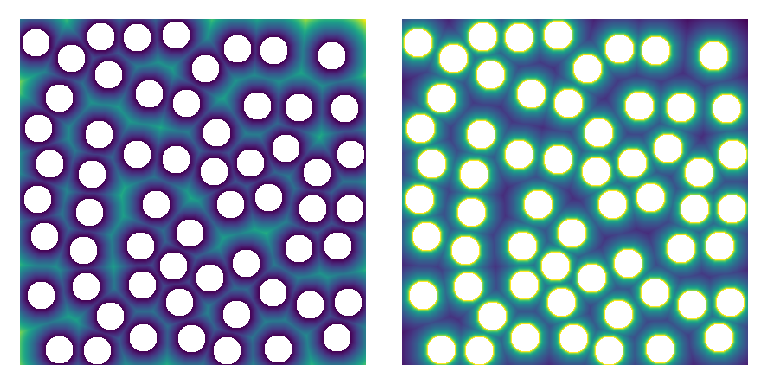

In [25]:
from edt import edt

fig, ax = plt.subplots(1, 2, figsize=(4, 8))
ax[0].imshow(edt(im)/im, interpolation='none', origin='lower')
ax[0].axis(False)
ax[1].imshow(np.log10(pc)/im, interpolation='none', origin='lower')
ax[1].axis(False);


### Run Drainage Simulation

We're now ready to perform the drainage simulation:

In [26]:
drn1 = ps.simulations.drainage(im=im, pc=pc, inlets=inlets, steps=10)

The function returns a `Results` object which is just a `dataclass` like object that has the resultant images attached as attributes.  It can be printed:

In [27]:
print(drn1)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of drainage generated at Fri Jun 20 15:05:01 2025
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im_snwp                   Array of size (400, 400)
im_seq                    Array of size (400, 400)
im_pc                     Array of size (400, 400)
im_trapped                None
im_size                   Array of size (400, 400)
pc                        Array of size (10,)
snwp                      Array of size (10,)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Here we see 3 images (prepended by `im_`).  These are the saturation map, the sequence map, and the capillary pressure map. 

### Displacement Maps: Sequence, Pressure, and Saturation Maps

Displacement maps allow the full history of the displacement simulation to be encoded in a single image.  These tell us the step number, global saturation, and phase pressure at which each voxel was invaded. Consider the sequence map from the `drn1` simulation we performed above shown below:

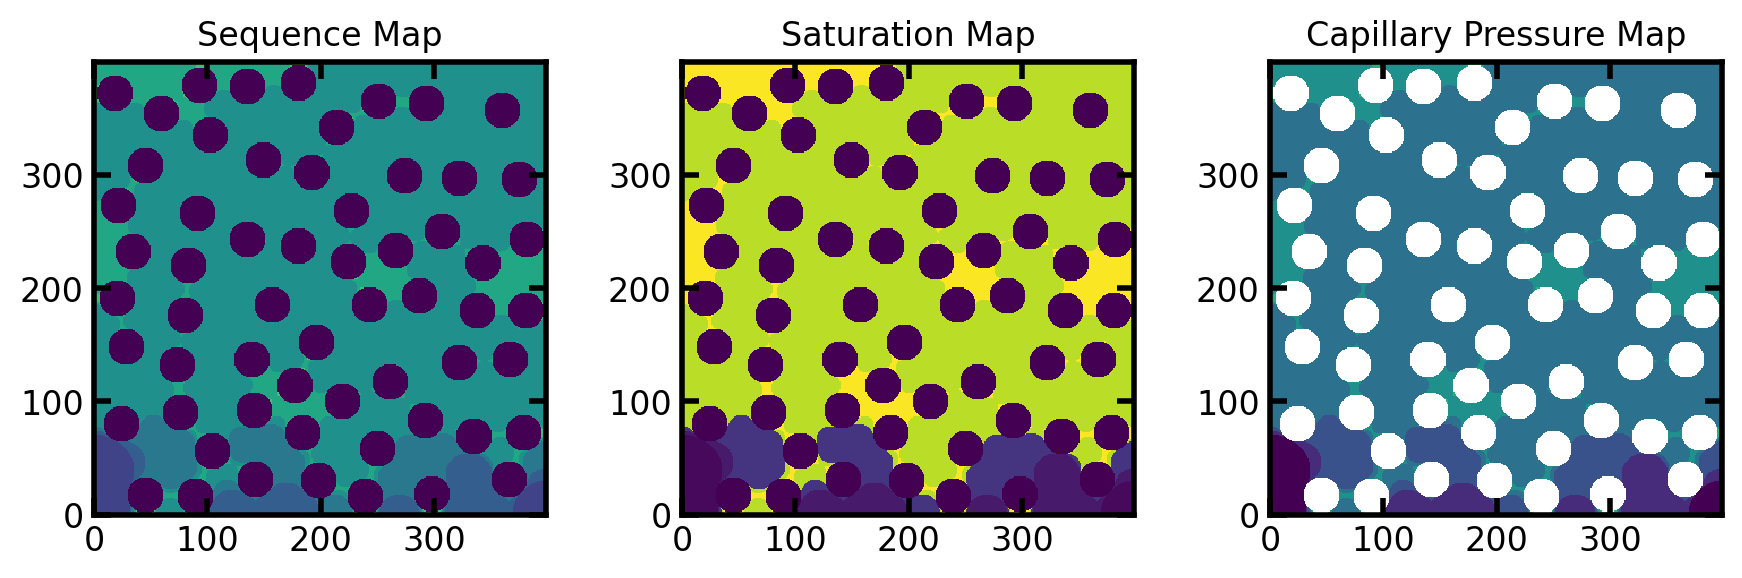

In [28]:
fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].imshow(drn1.im_seq)
ax[1].imshow(drn1.im_snwp)
ax[2].imshow(np.log10(drn1.im_pc))
ax[0].set_title("Sequence Map")
ax[1].set_title("Saturation Map")
ax[2].set_title("Capillary Pressure Map");

### Obtaining Fluid Configurations from Displacement Maps

The colors in the above sequence maps correspond to the step number at which each pixel was invaded.  With this information we can find the fluid configuration at each step as follows:

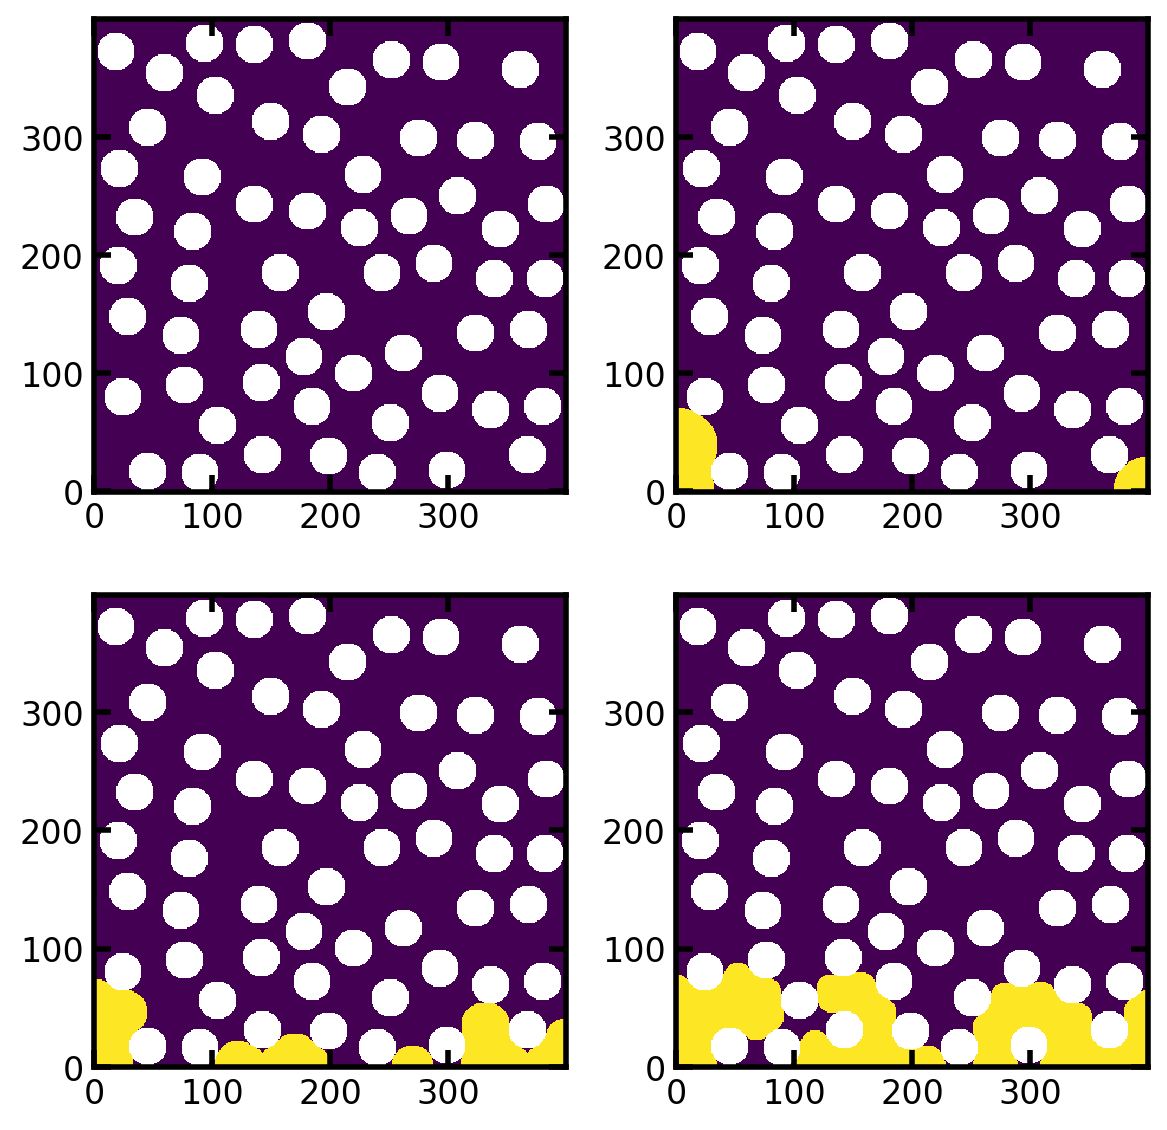

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0][0].imshow((drn1.im_seq <= 1)/im)
ax[0][1].imshow((drn1.im_seq <= 2)/im)
ax[1][0].imshow((drn1.im_seq <= 3)/im)
ax[1][1].imshow((drn1.im_seq <= 4)/im);

> Note: When generating the above images, the results were divided by the boolean image of the void space, which produces `inf` values in the solid locations.  These are are plotted as white, so this is a convenient way to indicate the solid phase without doing laborious adjustments on the colormap.

The same sort of images can be produced by applying thresholds to saturation map (`drn1.im_snwp`) and the capillary pressure map (`drn1.im_pc`).

### Generating Capillary Pressure Curves from Displacement Maps

Another useful feature of the displacement maps is that capillary pressure curves can be created from them. This can be accomplished by counting the number of voxels in the capillary pressure map that can be invaded at a given pressure. For instance:

In [30]:
Pc = np.unique(drn1.im_pc[im]).tolist()
satn = []
for p in Pc:
    nwp = (drn1.im_pc <= p)*im
    satn.append(nwp.sum()/im.sum())

We can plot this as follows:

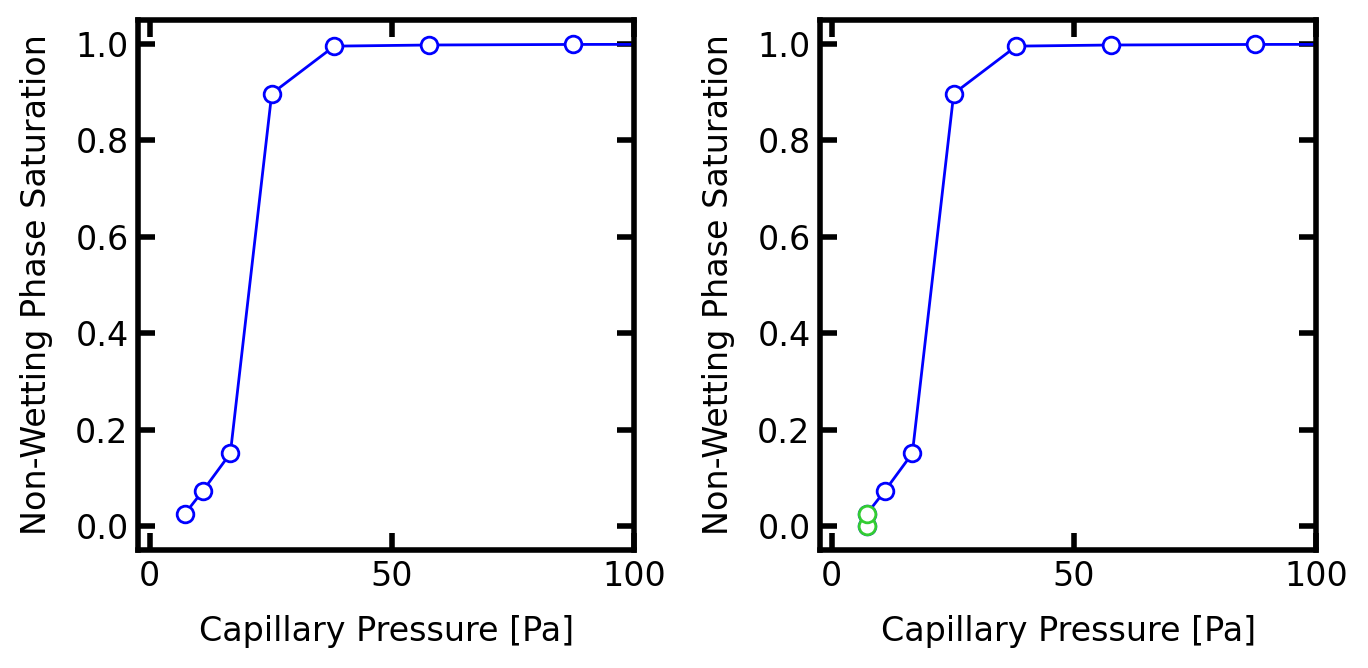

In [31]:
fig, ax = plt.subplots(1, 2, figsize=[7, 3.5])
ax[0].plot(Pc, satn, marker='o', markersize=6, linewidth=1, color='blue')
ax[0].set_xlabel('Capillary Pressure [Pa]')
ax[0].set_ylabel('Non-Wetting Phase Saturation')
ax[0].set_xlim([None, 100])
ax[0].set_ylim([-0.05, 1.05])

Pc.insert(0, Pc[0])
satn.insert(0, 0)
ax[1].plot(
    Pc,
    satn,
    marker='o',
    markersize=6,
    linewidth=1,
    color='blue',
)
ax[1].plot(
    Pc[:2],
    satn[:2],
    marker='o',
    markersize=6,
    linewidth=2,
    color='limegreen',
)
ax[1].set_xlabel('Capillary Pressure [Pa]')
ax[1].set_ylabel('Non-Wetting Phase Saturation')
ax[1].set_xlim([None, 100])
ax[1].set_ylim([-0.05, 1.05]);

When converting capillary pressure maps to capillary pressure curves the start and stop points of the curves must be considered carefully.  This is especially true when trapping and residual phases are present, as will be discussed below, but is also necessary when considering the basic case above.  The curve on the left graph starts around `(Pc, satn) = 7, 0.025)`, which occurs because the lowest capillary pressure present in the capillary pressure map is `9 Pa`.  The number of voxels invaded at this pressure represents a saturation of `0.025`. This implies that some residual non-wetting phase was present in the image prior to performing the simulation, but this is not the case.  This can be remedied by adding a point at `satn = 0` and `Pc = 7 Pa`, which is illustrated by the green segment in the right plot.  

PoreSpy includes a function to compute the `(Pc, Snwp)` values of the capillary curve from the capillary map: `porespy.metrics.pc_map_to_pc_curve`. This saves us the trouble having to create the plot as demonstrated above.

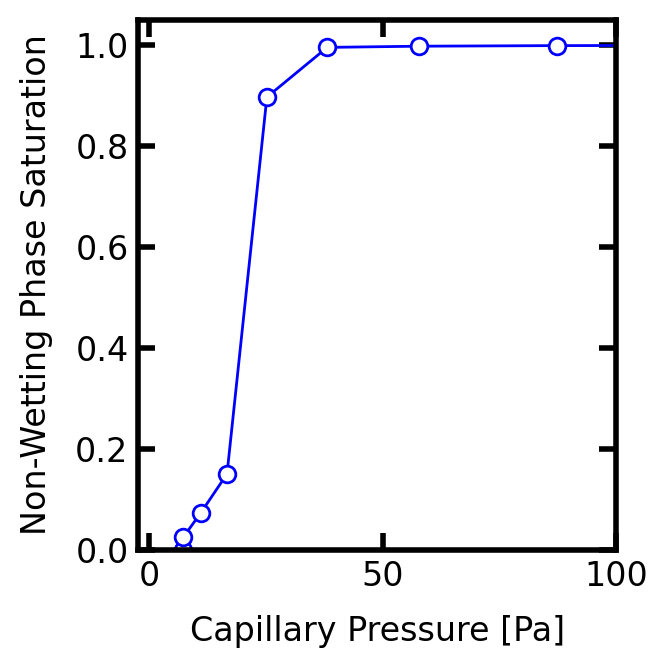

In [32]:
Pc, Snwp = ps.metrics.pc_map_to_pc_curve(
    im=im,
    pc=drn1.im_pc,
    mode='drainage',
)

fig, ax = plt.subplots(figsize=[3.5, 3.5])
ax.plot(
    Pc,
    Snwp,
    marker='o',
    markersize=6,
    linewidth=1,
    color='blue',
)
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_xlim([None, 100])
ax.set_ylim([0, 1.05]);

### Incorporating Trapping in Drainage

Trapping occurs when the defending fluid cannot exit from the domain because it becomes surrounded by the invading fluid. The `porespy.simulations.drainage` function can incorporate trapping in the output values. This will be applied automatically if the `outlets` are specified:

In [33]:
outlets = ps.generators.faces(im.shape, outlet=0)
drn2 = ps.simulations.drainage(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
    steps=20
)

This gives us the following displacment maps:

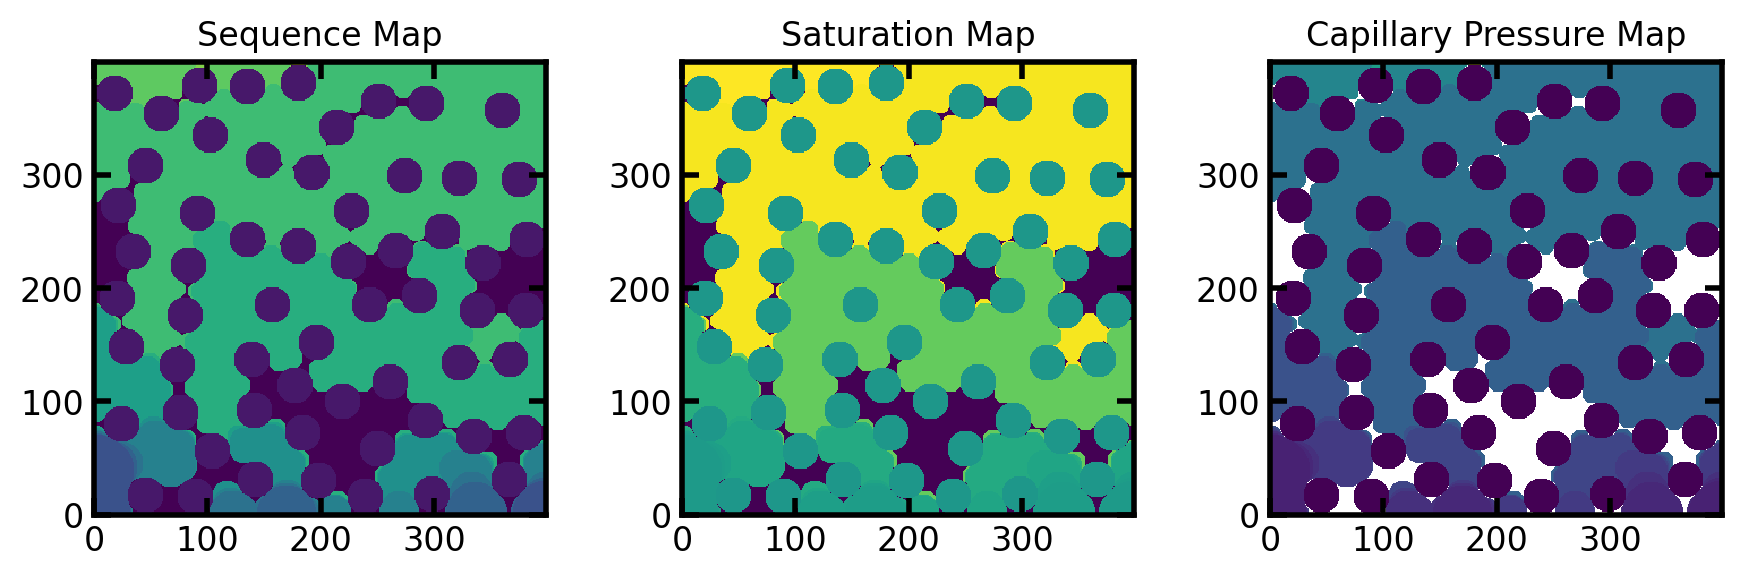

In [34]:
fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].imshow(drn2.im_seq)
ax[1].imshow(drn2.im_snwp)
ax[2].imshow(drn2.im_pc)
ax[0].set_title("Sequence Map")
ax[1].set_title("Saturation Map")
ax[2].set_title("Capillary Pressure Map");

In the above figures the trapped defending (wetting) phase can be seen. In the sequence and saturation maps, trapped voxels are indicated by `-1`.  This is makes sense since `-1` is not a valid value for either of these figures.  It also happens to work well when visualizing since these voxels we be noticeably darker. In the case of the capillary pressure map, `-1` is not a good option since this is a valid capillary pressure.  Instead trapped voxels are indicated by `+inf`, which physically means that these voxels were not invaded by non-wetting fluid ant *any* pressure. 

### Plotting Capillary Pressure Curves with Trapping

Plotting the capillary pressure curve as before shows that the final saturation reached by the invading fluid will be less than 1.0, which is occurs because the void space does not become completely filled by the invading fluid. This can be done by directly thresholding the the capillary pressure map, while being sure to only select values in the void space (i.e. mask out the solid values) and to exclude `+inf`:

In [35]:
Pc = np.unique(drn2.im_pc[im])  # Find all unique values in void
Pc = Pc[Pc < np.inf]  # Remove +inf if present

Snwp = []
for p in Pc:
    s = (drn2.im_pc[im] <= p).sum()/im.sum()
    Snwp.append(s)

# Remebering that we need to add some points to the beginning each
# each array to make the plot look correct:
Pc = np.hstack((Pc[0], Pc))
Snwp.insert(0, 0)

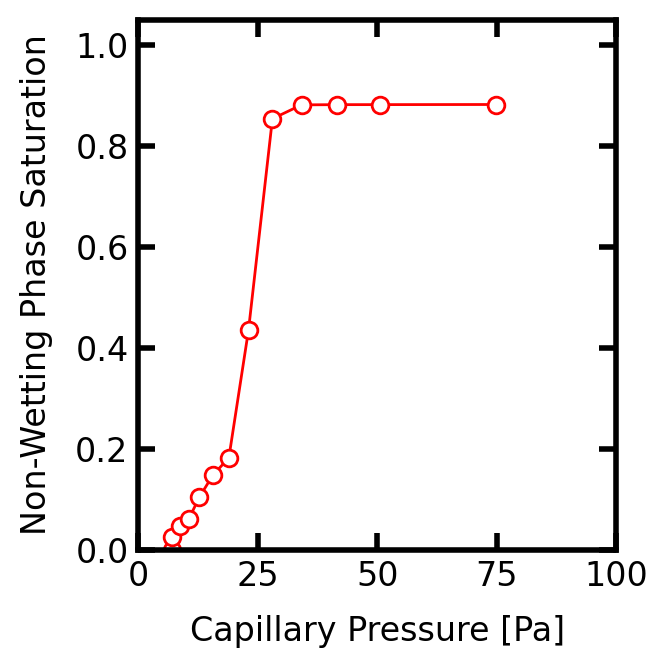

In [36]:
fig, ax = plt.subplots(figsize=[3.5, 3.5])
ax.plot(
    Pc,
    Snwp,
    marker='o',
    markersize=6,
    linewidth=1,
    color='red',
)
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_xlim([0, 100])
ax.set_ylim([0, 1.05]);

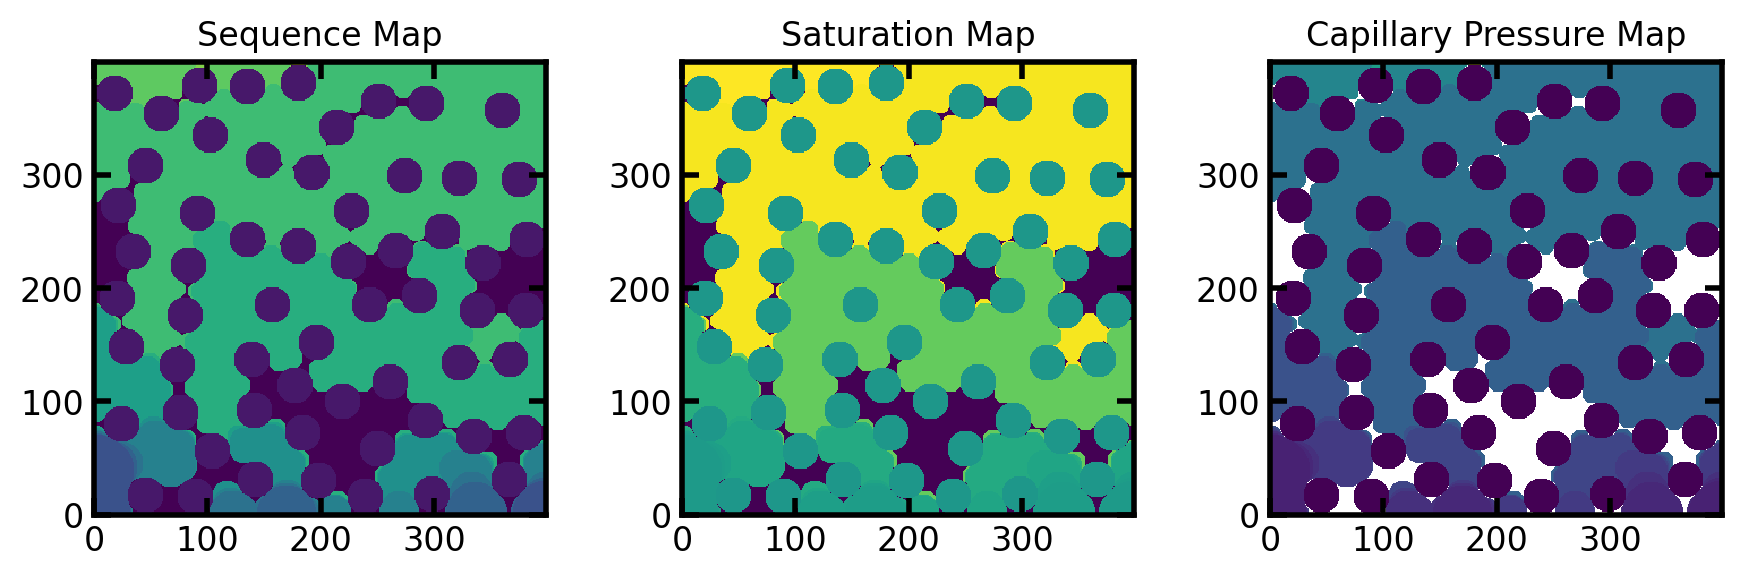

In [37]:
fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].imshow(drn2.im_seq)
ax[1].imshow(drn2.im_snwp)
ax[2].imshow(drn2.im_pc)
ax[0].set_title("Sequence Map")
ax[1].set_title("Saturation Map")
ax[2].set_title("Capillary Pressure Map");

Note that we could have used the `pc_map_to_pc_curve` function PoreSpy to accomplish the same plot:

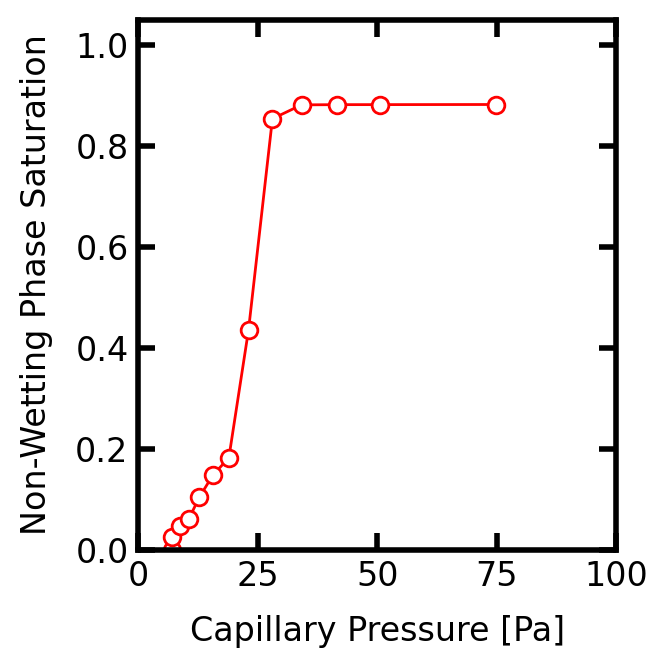

In [38]:
Pc, Snwp = ps.metrics.pc_map_to_pc_curve(
    pc=drn2.im_pc,
    im=im,
    mode='drainage',
)

fig, ax = plt.subplots(figsize=[3.5, 3.5])
ax.plot(
    Pc,
    Snwp,
    marker='o',
    markersize=6,
    linewidth=1,
    color='red',
)
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_xlim([0, 100])
ax.set_ylim([0, 1.05]);

### Incorporating Residual Non-Wetting Phase in Drainage

Because trapping is common in displacement simulations, it is also common to have residual phases present when beginning an invasion.  In the case of drainage, it is possible or even probable that some residual non-wetting phase may exist after a previous imbibition process.  

The `porespy.simulations.drainage` algorithm accepts a mask with `True` values indicating the which voxels are filled residual phase non-wetting.  This information is incorporated into the subsequent drainage process, meaning that the displacement will proceed following different steps since the residual phase allows connections to be made across regions that would otherwise be impenetrable at a given capillary pressure.  


To demonstrate, let's generate some blobs of residual non-wetting phase:

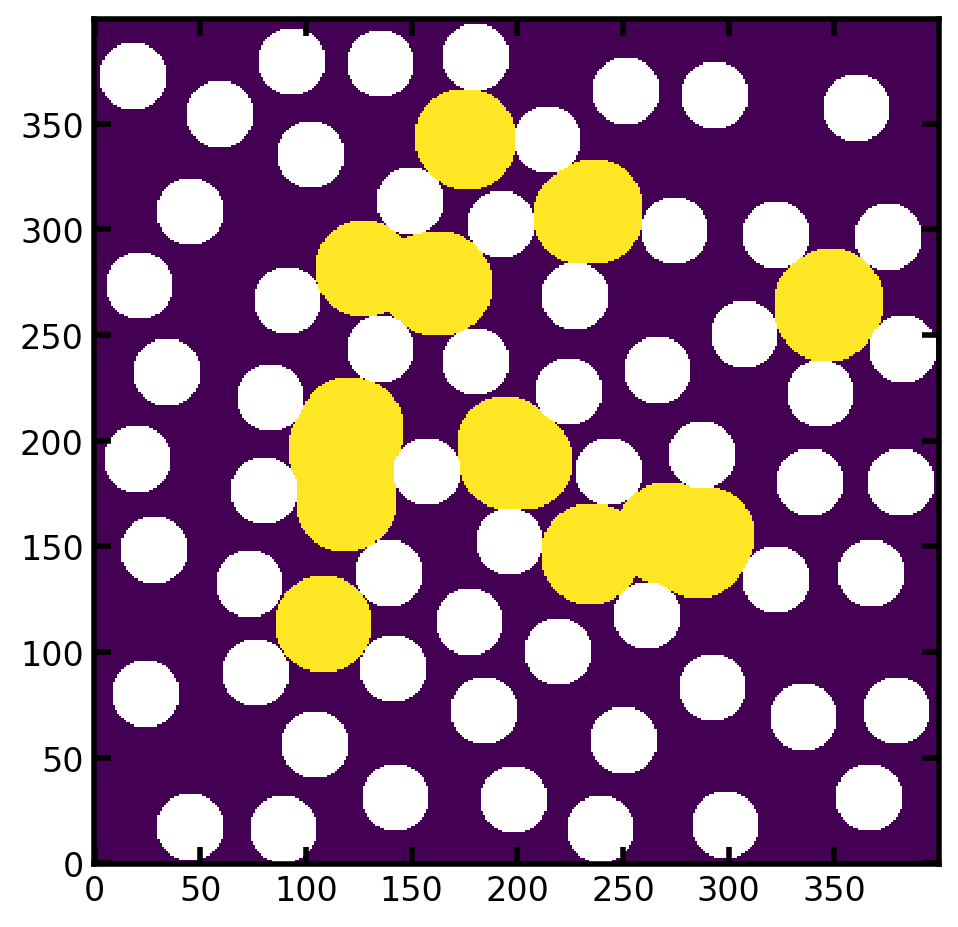

In [39]:
residual = ps.filters.local_thickness(im, sizes=[23]) > 0
residual = residual*~ps.filters.fill_closed_pores(residual)
plt.imshow(residual/im)

Now we can run the `drainage` function including the residual phase:

In [41]:
drn3 = ps.simulations.drainage(
    im=im,
    pc=pc,
    inlets=inlets,
    residual=residual,
    steps=20,
)

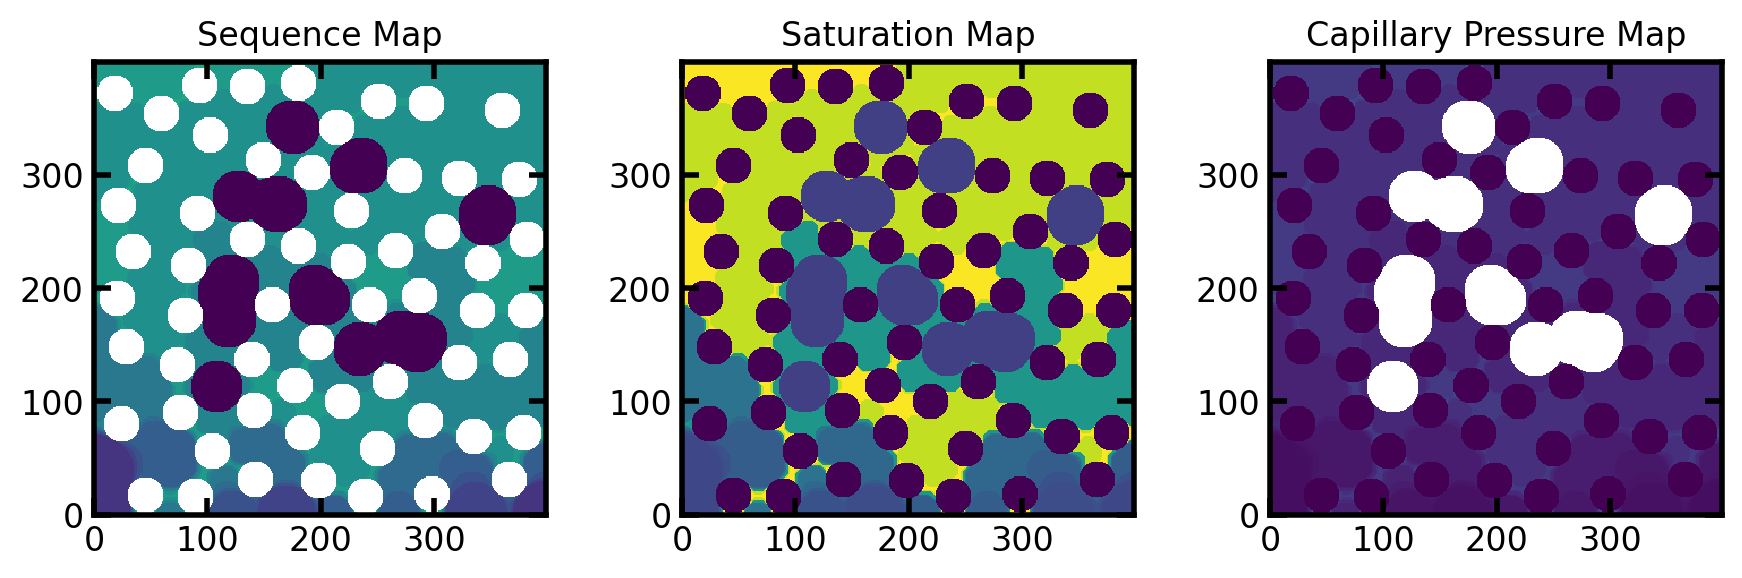

In [42]:
fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].imshow(drn3.im_seq/im)
ax[1].imshow(drn3.im_snwp)
ax[2].imshow(drn3.im_pc)
ax[0].set_title("Sequence Map")
ax[1].set_title("Saturation Map")
ax[2].set_title("Capillary Pressure Map");

Here we can see the resultant displacement maps including residual.  

The sequence map has been divided by `im` to make the solid phase render as white. The residual phase is given a sequence number of 0, because technically it was invaded at step 0. This is why the image was divided by `im`, since solid phase is also indicated by 0. 

In the saturation map, the residual phase is given the saturation that corresponds to the residual saturation. One limitation with this approach is that is it not clear what is residual phase, since it's possible that these voxels were just invaded early in the process (rather than prior to the process).  As such, when converting from saturation to sequence with `satn_to_seq` it is necessary to supply the `residual` image for the sequence values to be correct.

Additionally, in the capillary pressure map the residual phase is represented by `-inf`, which also renders as white in the above image.  This value makes physical sense since it implies that these voxels were filled with non-wetting phase at the start of the displacement, no matter how low the initial pressure was.  

> NOTE: At present it is not possible to include both residual non-wetting phase AND trapping in drainage (or injection) simulations. This is because any wetting phase which becomes trapped between the invading phase and the residual phase would technically be able to mobilize the residual blobs, but this is beyond the (current) capabilities of these algorithms. Instead of allowing non-physical behavior, the code will raise an error if one attempts to specify both `residual` and `outlets`.

### Plotting Capillary Curves with Residual and Trapped Phase

The methods demonstrated above for converting the capillary map to a capillary pressure curve work in the case of residual phase with a few extra considerations.  Namely, we need to add a point at some low capillary pressure and the residual saturation in order to make a horizontal line.  

In [43]:
Pc = np.unique(drn3.im_pc[im])  # Find all unique values in void
Pc = Pc[(Pc < np.inf)]  # Remove +inf if present

Snwp = []
for p in Pc:
    s = (drn3.im_pc[im] <= p).sum()/im.sum()
    Snwp.append(s)

Pc[0] = Pc[1]

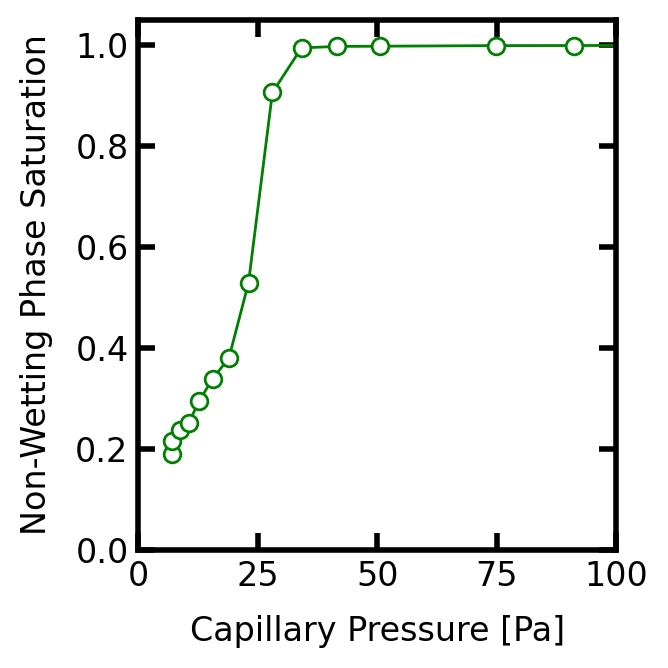

In [44]:
fig, ax = plt.subplots(figsize=[3.5, 3.5])
ax.plot(
    Pc,
    Snwp,
    marker='o',
    markersize=6,
    linewidth=1,
    color='green',
)
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_xlim([0, 100])
ax.set_ylim([0, 1.05]);

And as with the previous cases, this is all taken care of by the `pc_map_to_pc_curve` function:

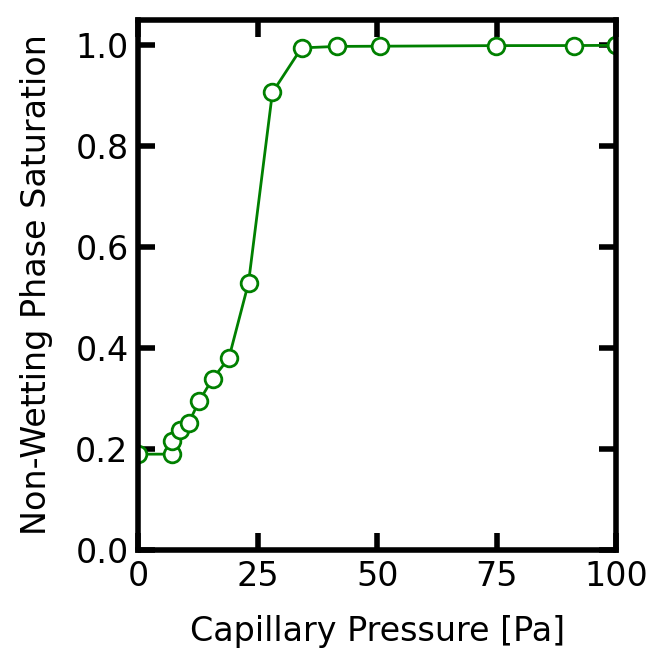

In [45]:
Pc, Snwp = ps.metrics.pc_map_to_pc_curve(
    pc=drn3.im_pc,
    im=im,
    pc_min=0,
    pc_max=100,
    mode='drainage',
)
fig, ax = plt.subplots(figsize=[3.5, 3.5])
ax.plot(
    Pc,
    Snwp,
    marker='o',
    markersize=6,
    linewidth=1,
    color='green',
)
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_xlim([0, 100])
ax.set_ylim([0, 1.05]);

## Summary

In summary we can plot all three simulations together as follows:

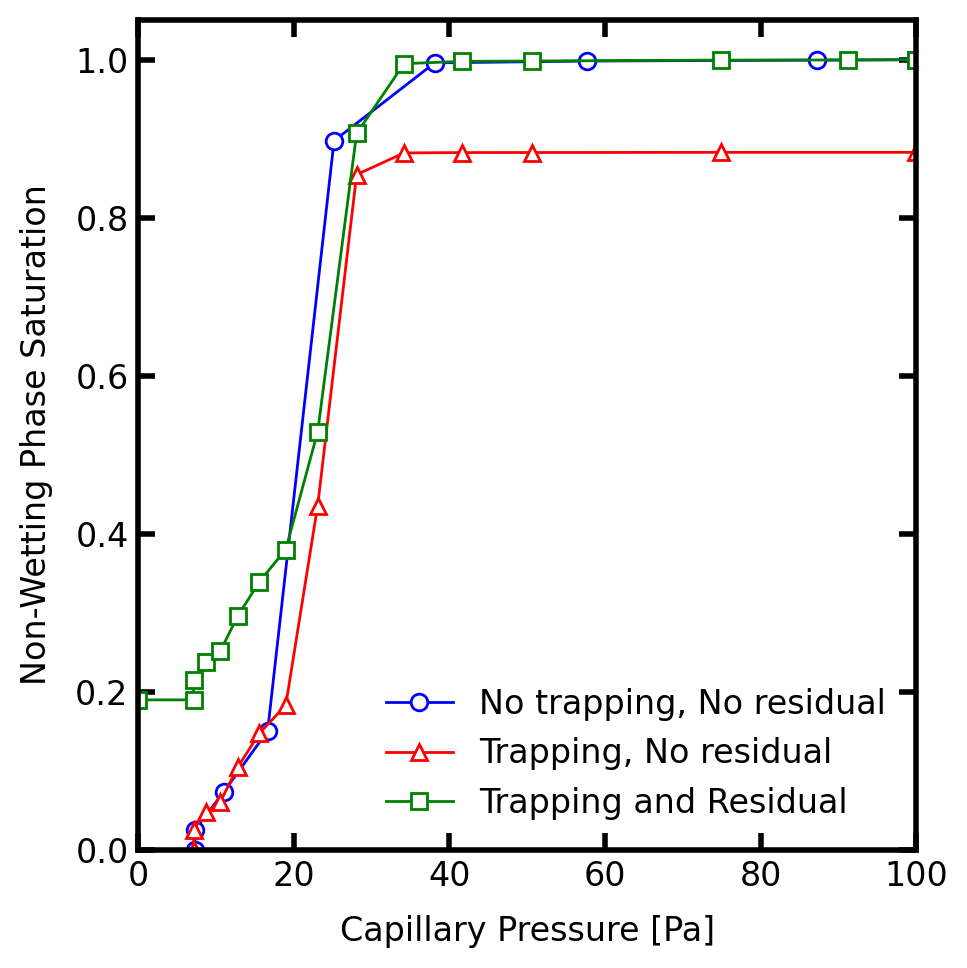

In [46]:
Pc1, Snwp1 = ps.metrics.pc_map_to_pc_curve(
    pc=drn1.im_pc,
    im=im,
    pc_min=0,
    pc_max=100,
    mode='drainage',
)
Pc2, Snwp2 = ps.metrics.pc_map_to_pc_curve(
    pc=drn2.im_pc,
    im=im,
    pc_min=0,
    pc_max=100,
    mode='drainage',
)
Pc3, Snwp3 = ps.metrics.pc_map_to_pc_curve(
    pc=drn3.im_pc,
    im=im,
    pc_min=0,
    pc_max=100,
    mode='drainage',
)

fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(
    Pc1,
    Snwp1,
    marker='o',
    color='blue',
    markersize=6,
    linewidth=1,
    label='No trapping, No residual',
)
ax.plot(
    Pc2,
    Snwp2,
    marker='^',
    color='red',
    markersize=6,
    linewidth=1,
    label='Trapping, No residual',
)
ax.plot(
    Pc3,
    Snwp3,
    marker='s',
    color='green',
    markersize=6,
    linewidth=1,
    label='Trapping and Residual',
)
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_xlim([0, 100])
ax.set_ylim([0, 1.05])
ax.legend();

The table below summarizes the conventions for how trapped and residual phase are noted in each of the different displacement maps.  Also provided in the table are the code snippets required to obtain a specific fluid configuration.

+-------------------+--------------+--------------+------------------------------------+
| Displacement Map  | Trapped  WP  | Residual NWP | Code to Generate Snwp              |
+-------------------+--------------+--------------+------------------------------------+
| Pc Map            | `inf`        | `-inf`       | `(im_pc <= p) * im`                |
+-------------------+--------------+--------------+------------------------------------+
| Sequence Map      | -1           | 0            | `(im_seq < N) * (im_seq >= 0)`     |
+-------------------+--------------+--------------+------------------------------------+
| Saturation Map    | -1           | $S_{nwp,r}$  | `(im_snwp < s) * (im_snwp > 0)`    |
+-------------------+--------------+--------------+------------------------------------+